<a href="https://colab.research.google.com/github/Vasyl808/deepfake_video_detection/blob/main/dfdc_cnn_lstm_balanced_ready.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!gdown --fuzzy https://drive.google.com/file/d/1KdufS2RjKU0kHtc5vxm7nx8iiyL_-h2g/view?usp=sharing -O dfdc.zip

Downloading...
From (original): https://drive.google.com/uc?id=1KdufS2RjKU0kHtc5vxm7nx8iiyL_-h2g
From (redirected): https://drive.google.com/uc?id=1KdufS2RjKU0kHtc5vxm7nx8iiyL_-h2g&confirm=t&uuid=0c54a612-f42f-4511-b30d-16297ca2d40b
To: /content/dfdc.zip
100% 4.44G/4.44G [00:53<00:00, 82.4MB/s]


In [3]:
!gdown --fuzzy https://drive.google.com/file/d/13GaVwQw_3fFYwoWc86oyhtlPEQjTQT69/view?usp=sharing -O archive_uadfv.zip

Downloading...
From (original): https://drive.google.com/uc?id=13GaVwQw_3fFYwoWc86oyhtlPEQjTQT69
From (redirected): https://drive.google.com/uc?id=13GaVwQw_3fFYwoWc86oyhtlPEQjTQT69&confirm=t&uuid=a74f5210-85f5-476f-b11a-8a0497455ffa
To: /content/archive_uadfv.zip
100% 153M/153M [00:01<00:00, 99.1MB/s]


In [4]:
!pip install facenet_pytorch --no-deps

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 20.6 MB/s eta 0:00:00


In [5]:
!unzip /content/dfdc.zip

Archive:  /content/dfdc.zip
  inflating: sample_submission.csv   
  inflating: test_videos/aassnaulhq.mp4  
  inflating: test_videos/aayfryxljh.mp4  
  inflating: test_videos/acazlolrpz.mp4  
  inflating: test_videos/adohdulfwb.mp4  
  inflating: test_videos/ahjnxtiamx.mp4  
  inflating: test_videos/ajiyrjfyzp.mp4  
  inflating: test_videos/aktnlyqpah.mp4  
  inflating: test_videos/alrtntfxtd.mp4  
  inflating: test_videos/aomqqjipcp.mp4  
  inflating: test_videos/apedduehoy.mp4  
  inflating: test_videos/apvzjkvnwn.mp4  
  inflating: test_videos/aqrsylrzgi.mp4  
  inflating: test_videos/axfhbpkdlc.mp4  
  inflating: test_videos/ayipraspbn.mp4  
  inflating: test_videos/bcbqxhziqz.mp4  
  inflating: test_videos/bcvheslzrq.mp4  
  inflating: test_videos/bdshuoldwx.mp4  
  inflating: test_videos/bfdopzvxbi.mp4  
  inflating: test_videos/bfjsthfhbd.mp4  
  inflating: test_videos/bjyaxvggle.mp4  
  inflating: test_videos/bkcyglmfci.mp4  
  inflating: test_videos/bktkwbcawi.mp4  
  inflatin

In [6]:
!unzip /content/archive_uadfv.zip

Archive:  /content/archive_uadfv.zip
  inflating: fake_videos/test/fake/0046_fake.mp4  
  inflating: fake_videos/test/fake/0047_fake.mp4  
  inflating: fake_videos/test/fake/0048_fake.mp4  
  inflating: fake_videos/test/real/0046.mp4  
  inflating: fake_videos/test/real/0047.mp4  
  inflating: fake_videos/test/real/0048.mp4  
  inflating: fake_videos/train/fake/0000_fake.mp4  
  inflating: fake_videos/train/fake/0001_fake.mp4  
  inflating: fake_videos/train/fake/0002_fake.mp4  
  inflating: fake_videos/train/fake/0003_fake.mp4  
  inflating: fake_videos/train/fake/0004_fake.mp4  
  inflating: fake_videos/train/fake/0005_fake.mp4  
  inflating: fake_videos/train/fake/0006_fake.mp4  
  inflating: fake_videos/train/fake/0007_fake.mp4  
  inflating: fake_videos/train/fake/0008_fake.mp4  
  inflating: fake_videos/train/fake/0009_fake.mp4  
  inflating: fake_videos/train/fake/0010_fake.mp4  
  inflating: fake_videos/train/fake/0011_fake.mp4  
  inflating: fake_videos/train/fake/0012_fake.mp

In [13]:
import cv2
import itertools
import json
import numpy as np
import pandas as pd
import random
from torch.nn import functional as F
import os.path
import time
import torch
from torch import nn
from torch.nn import functional
import glob
import datetime
import subprocess
from scipy.io import wavfile
from facenet_pytorch import MTCNN
import shutil


class FaceDeepfakeDataset(torch.utils.data.Dataset):
    def __init__(self, folders, n_frames=None, n_audio_reads=50027, train=True, device=None, cache_folder='/content/cache'):
        """n_audio_reads controls the length of the audio sequence: 5000 readings/sec."""
        self.n_frames = n_frames
        self.n_audio_reads = n_audio_reads
        self.videos = []
        self.train = train
        self.device = device if device is not None else torch.device("cpu")
        self.cache_folder = cache_folder
        self.detector = MTCNN(device=device, post_process=False)

        # Створюємо директорію кешування, якщо вона не існує
        if cache_folder and not os.path.exists(cache_folder):
            os.makedirs(cache_folder)

        for i in range(len(folders)):
            if train:
                if i == 0:
                    with open('/content/train_sample_videos/metadata.json') as f:
                        videos = json.load(f)
                        videos = [(os.path.join(folders[i], video), metadata) for (video, metadata) in videos.items()]
                        self.videos += videos
                else:
                    with open(os.path.join("/content/test.json")) as f:
                        videos = json.load(f)
                        videos = [(os.path.join(folders[i], video), metadata) for (video, metadata) in videos.items()]
                        self.videos += videos[:246]
            else:
                self.videos += glob.glob(folders[i] + "/*.mp4")

    def __process_frame(self, frame, video_id, frame_idx):
        cache_path = os.path.join(self.cache_folder, f"{video_id}_frame{frame_idx}.pt") if self.cache_folder else None

        # Якщо файл з кешем існує, завантажуємо його
        if cache_path and os.path.exists(cache_path):
            return torch.load(cache_path)

        # Інакше обробляємо кадр
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        boxes, _ = self.detector.detect(frame, landmarks=False)

        if boxes is None:
            return None
        else:
            box = boxes[0]
            width = box[2] - box[0]
            height = box[3] - box[1]
            expand_x = width * 0.3 / 2
            expand_y = height * 0.3 / 2
            x1 = max(int(box[0] - expand_x), 0)
            y1 = max(int(box[1] - expand_y), 0)
            x2 = min(int(box[2] + expand_x), frame.shape[1])
            y2 = min(int(box[3] + expand_y), frame.shape[0])

            face = frame[y1:y2, x1:x2]
            face = cv2.resize(face, (224, 224))
            face = torch.from_numpy(face).permute(2, 0, 1).float() / 255.0

            # Зберігаємо оброблений кадр у кеш
            if cache_path:
                torch.save(face, cache_path)

            return face

    def __pad_or_trim_frames(self, frames):
        if len(frames) == self.n_frames:
            return frames
        elif len(frames) < self.n_frames:
            # Дублюємо кадри, поки не досягнемо необхідної кількості
            num_repeats = (self.n_frames) // len(frames) + 1
            frames = frames * num_repeats
            frames = frames[:self.n_frames]
        elif len(frames) > self.n_frames:
            # Залишаємо тільки перші 30 кадрів
            frames = frames[:self.n_frames]
        return frames

    def __getitem__(self, n):
        if self.train:
            video, metadata = self.videos[n]
        else:
            video = self.videos[n]

        video_id = os.path.splitext(os.path.basename(video))[0]
        cap = cv2.VideoCapture(video)

        frames = []
        frame_idx = 0
        while len(frames) < self.n_frames:
            ret, frame = cap.read()
            if not ret:
                break

            processed_frame = self.__process_frame(frame, video_id, frame_idx)
            if processed_frame is not None:
                frames.append(processed_frame)
            frame_idx += 1

        cap.release()
        frames = self.__pad_or_trim_frames(frames)
        frames = torch.stack(frames).to(self.device)

        if self.train:
            label = 0.0 if metadata['label'] == 'REAL' else 1.0
            return frames, torch.FloatTensor([label]).to(self.device)
        else:
            return frames

    def __len__(self):
        return len(self.videos)

In [14]:
class FaceDeepfakeDatasetTest(torch.utils.data.Dataset):
    def __init__(self, folders, n_frames=None, n_audio_reads=50027, train=True, device=None, cache_folder=None):
        """n_audio_reads controls the length of the audio sequence: 5000 readings/sec."""
        self.n_frames = n_frames
        self.n_audio_reads = n_audio_reads
        self.videos = []
        self.train = train
        self.device = device if device is not None else torch.device("cpu")
        self.cache_folder = cache_folder
        self.detector = MTCNN(device=device, post_process=False)
        for i in range(len(folders)):
            if train:
                #print(folders[i])
                for item in os.listdir(folders[i]):
                    item_path = os.path.join(folders[i], item)
                    if str(os.path.basename(item_path)) == 'fake':
                        for curr in os.listdir(item_path):
                            if os.path.isfile(os.path.join(item_path, curr)):
                                metadata = {}
                                metadata['label']='fake'
                                self.videos += [(os.path.join(item_path, curr), metadata)]
                    else:
                        for item_file in os.listdir(item_path):
                            if os.path.isfile(os.path.join(item_path, item_file)):
                                metadata = {}
                                metadata['label']='real'
                                self.videos += [(os.path.join(item_path, item_file), metadata)]
            else:
                self.videos += glob.glob(folders[i] + "/*.mp4")

    def __process_frame(self, frame):
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        boxes, _ = self.detector.detect(frame, landmarks=False)  # Отримуємо координати обличчя

        if boxes is None:
            # Повертаємо порожній кадр, якщо обличчя не знайдено
            face = torch.zeros((3, 224, 224))
        else:
            # Беремо перше обличчя (якщо знайдено кілька)
            box = boxes[0]

            # Розширюємо рамку на 30%
            width = box[2] - box[0]
            height = box[3] - box[1]
            expand_x = width * 0.3 / 2
            expand_y = height * 0.3 / 2
            x1 = max(int(box[0] - expand_x), 0)
            y1 = max(int(box[1] - expand_y), 0)
            x2 = min(int(box[2] + expand_x), frame.shape[1])
            y2 = min(int(box[3] + expand_y), frame.shape[0])

            # Обрізаємо зображення за новими координатами
            face = frame[y1:y2, x1:x2]
            face = cv2.resize(face, (224, 224))  # Масштабуємо до 300x300

            # Перетворюємо на тензор і нормалізуємо
            face = torch.from_numpy(face).permute(2, 0, 1).float() / 255.0

        return face

    def __getitem__(self, n):
        if self.train:
            video, metadata = self.videos[n]
        else:
            video = self.videos[n]

        # Processing video frames
        if os.path.islink(video):
            video = os.readlink(video)

        cap = cv2.VideoCapture(video)

        frames = []
        for _ in range(self.n_frames):
            ret, frame = cap.read()
            if not ret:
                break
            frames.append(self.__process_frame(frame))
        '''total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        step = max(1, total_frames // self.n_frames)

        for i in range(self.n_frames):
            cap.set(cv2.CAP_PROP_POS_FRAMES, i * step)
            ret, frame = cap.read()
            if ret:
                frames.append(self.__process_frame(frame))
            else:
                break'''
        cap.release()
        frames = torch.stack(frames).to(self.device)

        # Return data
        if self.train:
            label = 0.0
            if metadata['label'] == 'fake':
                label = 1.0
            return frames, torch.FloatTensor([label]).to(self.device)
        else:
            return frames

    def __len__(self):
        return len(self.videos)

In [15]:
import torch
import torch.nn as nn
import math
from torch.nn import functional as F
import torchvision.models as models


class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.attention_weights = nn.Linear(hidden_dim * 2, 1)  # для bidirectional LSTM подвоюємо розмір hidden_dim

    def forward(self, lstm_out):
        # lstm_out має розмір (batch_size, num_frames, hidden_dim * 2)
        weights = self.attention_weights(lstm_out)  # (batch_size, num_frames, 1)
        weights = F.softmax(weights, dim=1)  # Знаходимо ваги з активацією softmax

        # Вагове середнє по кадрам
        attention_output = torch.sum(weights * lstm_out, dim=1)  # (batch_size, hidden_dim * 2)
        return attention_output


class FaceClassifier(nn.Module):
    def __init__(self, n_linear_hidden=256, lstm_hidden_dim=256, num_lstm_layers=1):
        super(FaceClassifier, self).__init__()

        # Завантаження попередньо натренованої EfficientNet
        self.cnn = models.efficientnet_b7(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(self.cnn.children())[:-1])

        for param in self.feature_extractor.parameters():
            param.requires_grad = False

        self.feature_output_size = 2560  # EfficientNet B7 дає 2560 ознак

        # LSTM для обробки послідовності ознак кожного кадру
        self.lstm = nn.LSTM(input_size=self.feature_output_size,
                            hidden_size=lstm_hidden_dim,
                            num_layers=num_lstm_layers,
                            batch_first=True,
                            bidirectional=True)

        # Шар уваги
        self.attention = Attention(lstm_hidden_dim)

        # Повнозв'язні шари для класифікації
        self.fc1 = nn.Linear(2 * lstm_hidden_dim, n_linear_hidden)
        self.fc2 = nn.Linear(n_linear_hidden, 1)

    def forward(self, vid_frames):
        batch_size, num_frames, channels, height, width = vid_frames.shape
        vid_frames = vid_frames.view(batch_size * num_frames, channels, height, width)

        # Використовуємо фічерний екстрактор
        with torch.no_grad():
            vid_features = self.feature_extractor(vid_frames)

        vid_features = vid_features.view(batch_size, num_frames, -1)  # (batch_size, num_frames, feature_output_size)

        # Обробка послідовності кадрів через LSTM
        lstm_out, _ = self.lstm(vid_features)  # lstm_out: (batch_size, num_frames, 2 * lstm_hidden_dim)

        # Використовуємо шар уваги для зваженого усереднення кадрів
        x = self.attention(lstm_out)  # (batch_size, 2 * lstm_hidden_dim)

        # Класифікаційні шари
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)

        return x

all train folders: ['/content/train_sample_videos', '/content/test_videos'], <class 'list'>
all test folders: ['/content/fake_videos/train'], <class 'list'>
start time: 2024-11-10 10:45:26.900217
using device: cuda
81


3it [01:33, 30.77s/it]<ipython-input-13-7f1b9301cb05>:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(cache_path)
81it [41:13, 30.53s/it]


[[220 103]
 [ 56 267]]


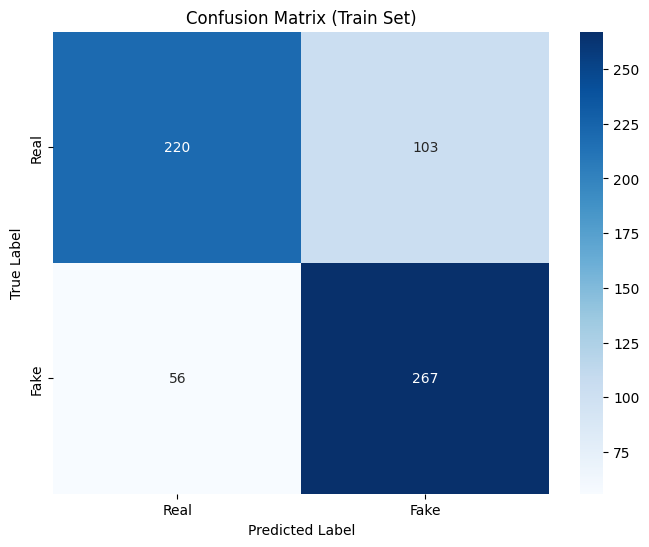

Classification Report (Train Set):
              precision    recall  f1-score   support

        Real       0.80      0.68      0.73       323
        Fake       0.72      0.83      0.77       323

    accuracy                           0.75       646
   macro avg       0.76      0.75      0.75       646
weighted avg       0.76      0.75      0.75       646


epoch: 0, train loss: 0.4798157492905487, valid loss: 3.5331886993213133 executed in: 2594.613514184952
train total: 646, train correct: 487.0, train incorrect: 159.0, train accuracy: 0.7538699507713318
valid total: 82, valid correct: 39.0, valid incorrect: 43.0, valid accuracy: 0.47560974955558777


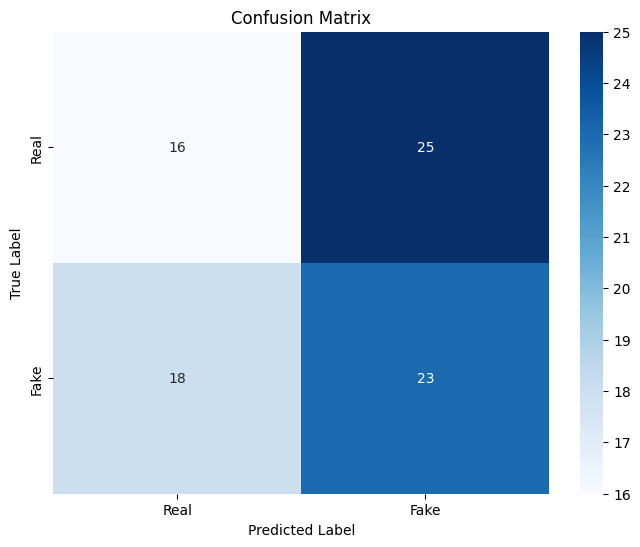

Classification Report:
              precision    recall  f1-score   support

        Real       0.47      0.39      0.43        41
        Fake       0.48      0.56      0.52        41

    accuracy                           0.48        82
   macro avg       0.47      0.48      0.47        82
weighted avg       0.47      0.48      0.47        82



0it [00:00, ?it/s]<ipython-input-13-7f1b9301cb05>:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(cache_path)
81it [11:47,  8.73s/it]


[[260  63]
 [ 23 300]]


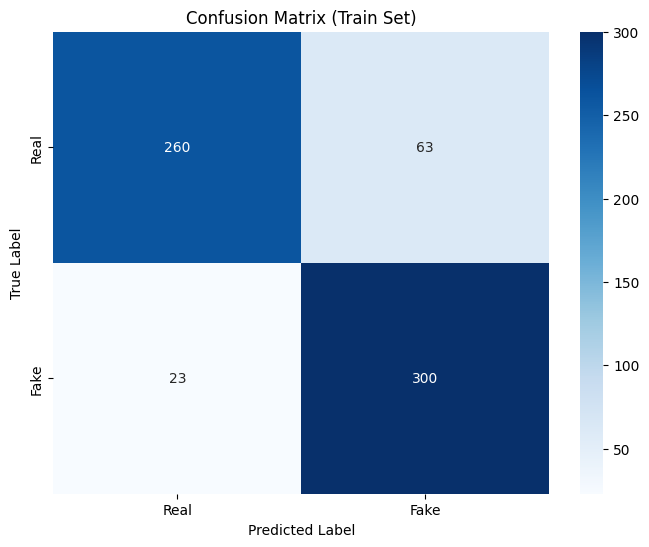

Classification Report (Train Set):
              precision    recall  f1-score   support

        Real       0.92      0.80      0.86       323
        Fake       0.83      0.93      0.87       323

    accuracy                           0.87       646
   macro avg       0.87      0.87      0.87       646
weighted avg       0.87      0.87      0.87       646


epoch: 1, train loss: 0.34047936491760206, valid loss: 2.5071662325750697 executed in: 826.731644153595
train total: 646, train correct: 560.0, train incorrect: 86.0, train accuracy: 0.866873025894165
valid total: 82, valid correct: 40.0, valid incorrect: 42.0, valid accuracy: 0.4878048598766327


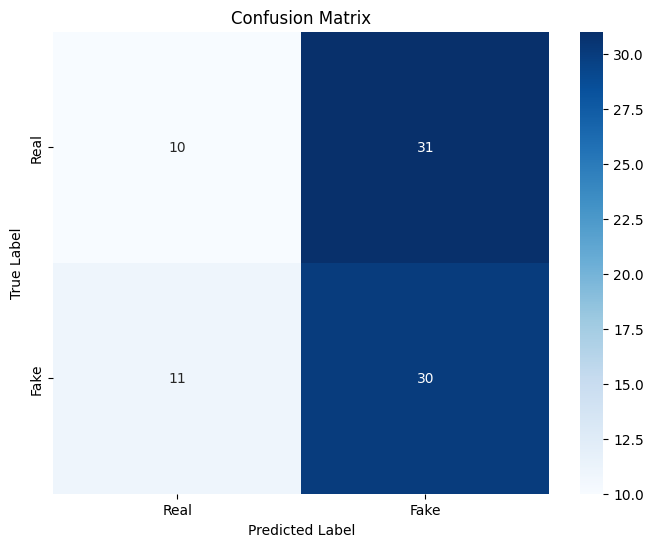

Classification Report:
              precision    recall  f1-score   support

        Real       0.48      0.24      0.32        41
        Fake       0.49      0.73      0.59        41

    accuracy                           0.49        82
   macro avg       0.48      0.49      0.46        82
weighted avg       0.48      0.49      0.46        82



0it [00:00, ?it/s]<ipython-input-13-7f1b9301cb05>:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(cache_path)
81it [11:53,  8.81s/it]


[[270  53]
 [ 20 303]]


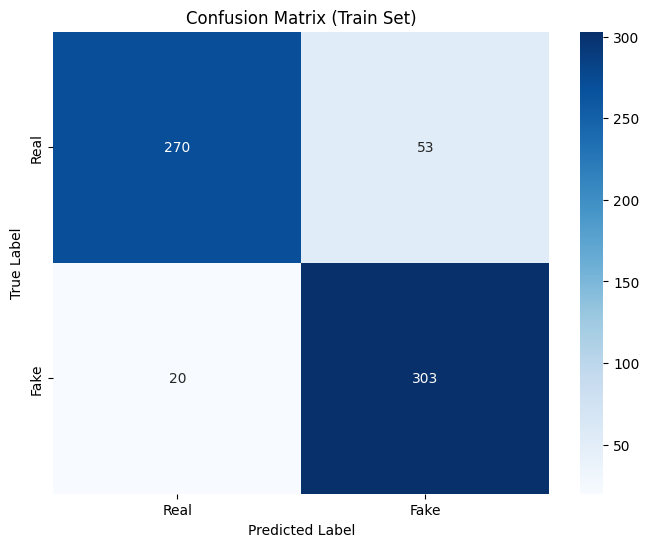

Classification Report (Train Set):
              precision    recall  f1-score   support

        Real       0.93      0.84      0.88       323
        Fake       0.85      0.94      0.89       323

    accuracy                           0.89       646
   macro avg       0.89      0.89      0.89       646
weighted avg       0.89      0.89      0.89       646


epoch: 2, train loss: 0.2943715795782613, valid loss: 2.1676452678035605 executed in: 832.3353123664856
train total: 646, train correct: 573.0, train incorrect: 73.0, train accuracy: 0.886996865272522
valid total: 82, valid correct: 43.0, valid incorrect: 39.0, valid accuracy: 0.5243902206420898


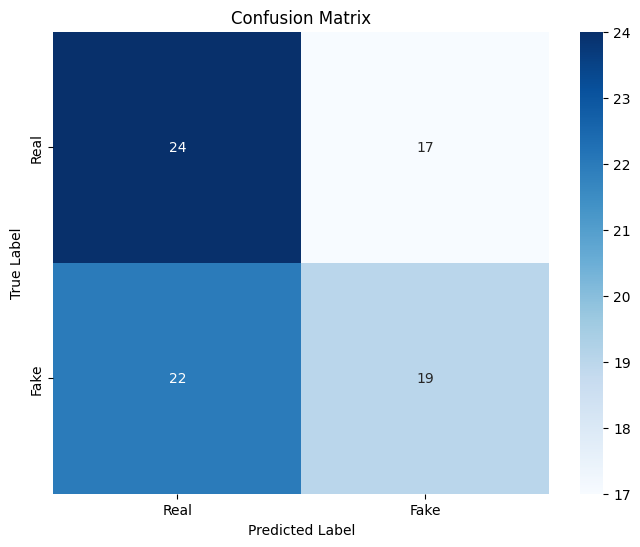

Classification Report:
              precision    recall  f1-score   support

        Real       0.52      0.59      0.55        41
        Fake       0.53      0.46      0.49        41

    accuracy                           0.52        82
   macro avg       0.52      0.52      0.52        82
weighted avg       0.52      0.52      0.52        82



0it [00:00, ?it/s]<ipython-input-13-7f1b9301cb05>:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(cache_path)
81it [11:57,  8.86s/it]


[[291  32]
 [ 20 303]]


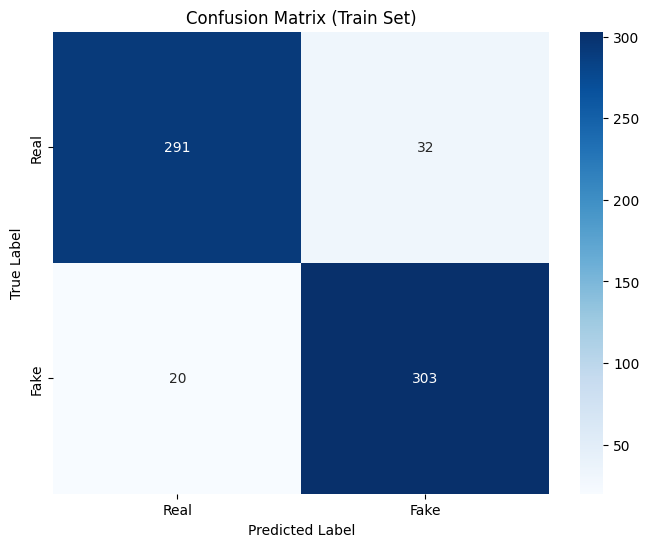

Classification Report (Train Set):
              precision    recall  f1-score   support

        Real       0.94      0.90      0.92       323
        Fake       0.90      0.94      0.92       323

    accuracy                           0.92       646
   macro avg       0.92      0.92      0.92       646
weighted avg       0.92      0.92      0.92       646


epoch: 3, train loss: 0.21660126082277226, valid loss: 1.5949729206040502 executed in: 837.2274644374847
train total: 646, train correct: 594.0, train incorrect: 52.0, train accuracy: 0.9195046424865723
valid total: 82, valid correct: 40.0, valid incorrect: 42.0, valid accuracy: 0.4878048598766327


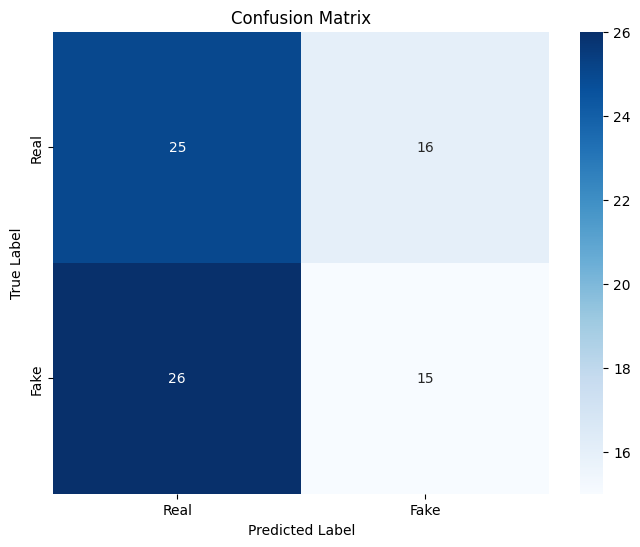

Classification Report:
              precision    recall  f1-score   support

        Real       0.49      0.61      0.54        41
        Fake       0.48      0.37      0.42        41

    accuracy                           0.49        82
   macro avg       0.49      0.49      0.48        82
weighted avg       0.49      0.49      0.48        82



0it [00:00, ?it/s]<ipython-input-13-7f1b9301cb05>:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(cache_path)
81it [11:46,  8.72s/it]


[[293  30]
 [ 18 305]]


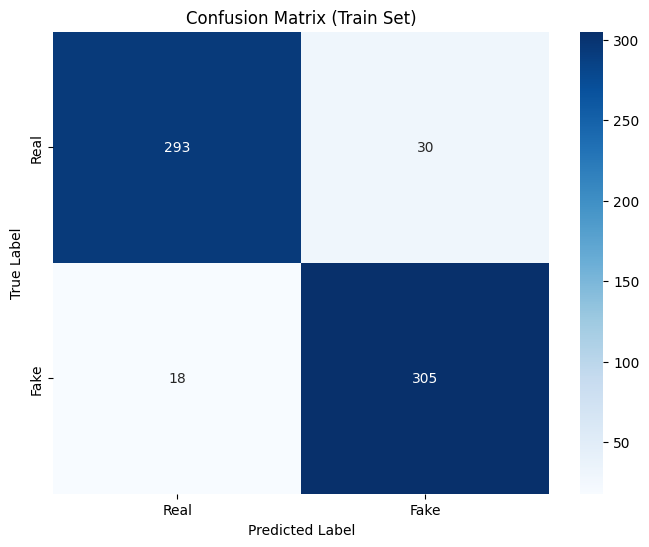

Classification Report (Train Set):
              precision    recall  f1-score   support

        Real       0.94      0.91      0.92       323
        Fake       0.91      0.94      0.93       323

    accuracy                           0.93       646
   macro avg       0.93      0.93      0.93       646
weighted avg       0.93      0.93      0.93       646


epoch: 4, train loss: 0.16906045849239568, valid loss: 1.244899739807641 executed in: 823.5910613536835
train total: 646, train correct: 598.0, train incorrect: 48.0, train accuracy: 0.9256965517997742
valid total: 82, valid correct: 42.0, valid incorrect: 40.0, valid accuracy: 0.5121951103210449


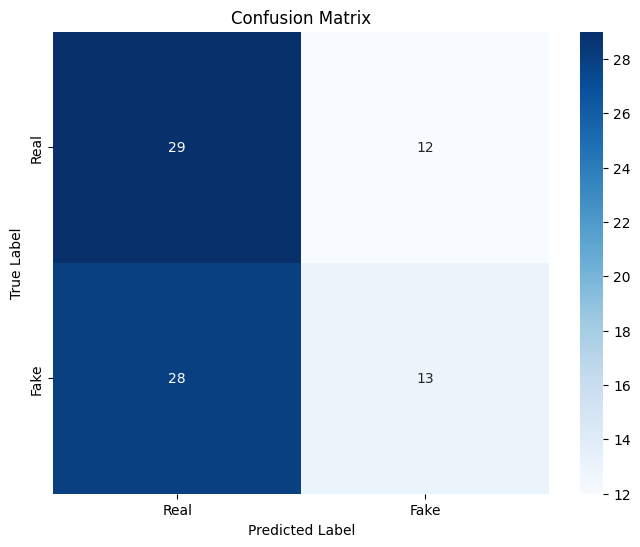

Classification Report:
              precision    recall  f1-score   support

        Real       0.51      0.71      0.59        41
        Fake       0.52      0.32      0.39        41

    accuracy                           0.51        82
   macro avg       0.51      0.51      0.49        82
weighted avg       0.51      0.51      0.49        82



0it [00:00, ?it/s]<ipython-input-13-7f1b9301cb05>:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(cache_path)
81it [11:49,  8.76s/it]


[[297  26]
 [ 21 302]]


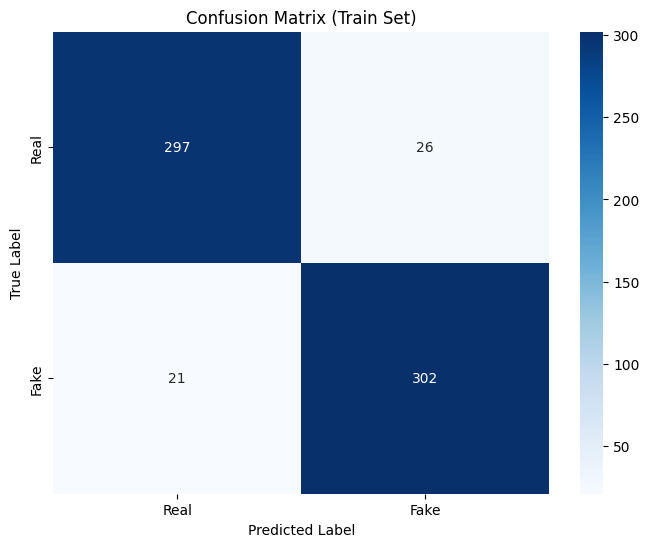

Classification Report (Train Set):
              precision    recall  f1-score   support

        Real       0.93      0.92      0.93       323
        Fake       0.92      0.93      0.93       323

    accuracy                           0.93       646
   macro avg       0.93      0.93      0.93       646
weighted avg       0.93      0.93      0.93       646


epoch: 5, train loss: 0.19664129910323722, valid loss: 1.4479950206692924 executed in: 828.1632997989655
train total: 646, train correct: 599.0, train incorrect: 47.0, train accuracy: 0.9272445440292358
valid total: 82, valid correct: 35.0, valid incorrect: 47.0, valid accuracy: 0.4268292486667633


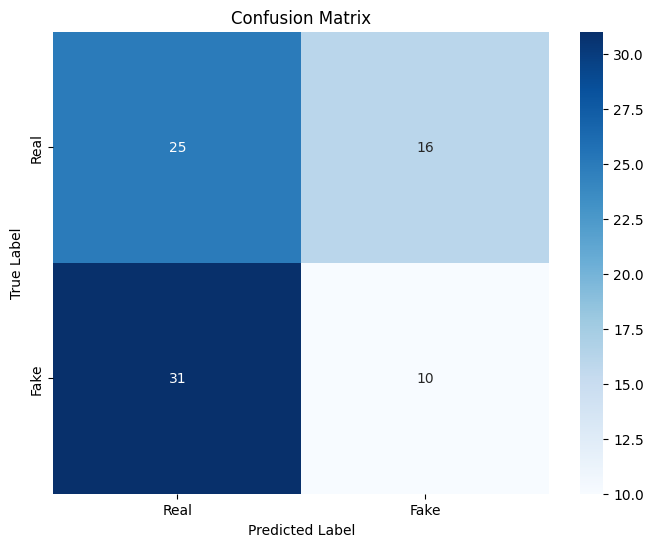

Classification Report:
              precision    recall  f1-score   support

        Real       0.45      0.61      0.52        41
        Fake       0.38      0.24      0.30        41

    accuracy                           0.43        82
   macro avg       0.42      0.43      0.41        82
weighted avg       0.42      0.43      0.41        82



0it [00:00, ?it/s]<ipython-input-13-7f1b9301cb05>:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(cache_path)
8it [01:05,  8.24s/it]


KeyboardInterrupt: 

In [16]:
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
import datetime
import sys
import pandas as pd
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision


train_folders = ['/content/train_sample_videos', '/content/test_videos']

test_folders = [os.path.join("/content/", "fake_videos", "train")]

batch_size = int(8)
num_epochs = int(8)
n_frames = int(30)
lr = float(0.001)

TRAIN_FOLDERS = train_folders
TEST_FOLDERS = test_folders
print(f"all train folders: {train_folders}, {type(train_folders)}")
print(f"all test folders: {test_folders}, {type(test_folders)}")

milestones = [6,12,18]
gamma = 0.1


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = FaceClassifier()
#model.load_state_dict(torch.load('/content/maybe_done_dfdc_balanced_4_classifier_30_small.pt', map_location=device))
model = model.to(device)
class_weights = {0: 0.6191950464396285, 1: 2.5974025974025974}
weights_tensor = torch.tensor([class_weights[0], class_weights[1]], dtype=torch.float32).to(device)

# Modify the loss function
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)

start_time = datetime.datetime.now()
print(f'start time: {str(start_time)}')
print(f'using device: {device}')

'''Splitting into Train and Validation'''
train_dataset = FaceDeepfakeDataset(TRAIN_FOLDERS,  n_frames=n_frames, n_audio_reads=576, device=device, cache_folder="face_encode_cache")
test_dataset = FaceDeepfakeDatasetTest(TEST_FOLDERS, n_frames=n_frames, n_audio_reads=576, device=device)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
print(len(train_loader))

'''Train_Loop'''
train_losses = []
val_losses = []
best_loss = np.inf
train_accuracies = []
val_accuracies = []
epoch_times = []


for epoch in range(num_epochs):
    epoch_start_time = time.time()
    epoch_t_loss = 0
    epoch_v_loss = 0
    t_count = 0
    t_count_wrong = 0
    train_labels_all = []
    train_preds_all = []

    model.train()
    torch.cuda.empty_cache()
    for i, batch in tqdm(enumerate(train_loader)):
        # if i * batch_size >= epoch_size:
        #     break
        video_data, labels = batch
        video_data = video_data.to(device)
        #audio_data = audio_data.to(device)

        output = model(video_data)
        loss = criterion(output, labels)

        output = torch.sigmoid(output)
        output = output.round()

        n_wrong = (labels - output).abs().sum()
        t_count_wrong += n_wrong
        t_count += labels.shape[0]

        epoch_t_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_labels_all.extend(labels.cpu().detach().numpy())
        train_preds_all.extend(output.cpu().detach().numpy())

        #print('.', end='', flush=True)
        torch.cuda.empty_cache()

    # Перетворіть на numpy-масиви
    train_labels_all = np.array(train_labels_all).astype(int)
    train_preds_all = np.array(train_preds_all).astype(int)

    # Обчисліть та виведіть матрицю плутанини для тренувального набору
    conf_matrix_train = confusion_matrix(train_labels_all, train_preds_all)
    print(conf_matrix_train)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix (Train Set)')
    plt.show()

    # Виведіть класифікаційний звіт для тренувального набору
    print("Classification Report (Train Set):")
    print(classification_report(train_labels_all, train_preds_all, target_names=['Real', 'Fake']))

    all_labels = []
    all_preds = []

    model.eval()
    with torch.no_grad():
        v_count = 0
        v_count_wrong = 0
        for i, batch in enumerate(val_loader):
            # if i * batch_size >= epoch_size:
        #        break
            video_data, labels = batch
            video_data = video_data.to(device)
            #audio_data = audio_data.to(device)
            # optimizer.zero_grad()
            output = model(video_data)
            loss = criterion(output, labels)

            output = torch.sigmoid(output)
            output = output.round()
            n_wrong = (labels - output).abs().sum()
            v_count_wrong += n_wrong
            v_count += labels.shape[0]

            epoch_v_loss += loss.item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(output.cpu().numpy())

            #loss.backward()
            #optimizer.step()
            #print('.', end='', flush=True)

    epoch_end_time = time.time()
    epoch_exec_time = epoch_end_time - epoch_start_time
    epoch_times.append(epoch_exec_time)
    train_losses.append(epoch_t_loss/len(train_loader))
    val_losses.append(epoch_t_loss/len(val_loader))

    t_count_right = t_count - t_count_wrong
    v_count_right = v_count - v_count_wrong
    t_accuracy = t_count_right / t_count
    v_accuracy = v_count_right / v_count

    train_accuracies.append(t_accuracy)
    val_accuracies.append(v_accuracy)

    print(f'\nepoch: {epoch}, train loss: {train_losses[-1]}, valid loss: {val_losses[-1]} executed in: {str(epoch_exec_time)}')
    print(f"train total: {t_count}, train correct: {t_count_right}, train incorrect: {t_count_wrong}, train accuracy: {t_accuracy}")
    print(f"valid total: {v_count}, valid correct: {v_count_right}, valid incorrect: {v_count_wrong}, valid accuracy: {v_accuracy}")
    all_labels = np.array(all_labels).astype(int)
    all_preds = np.array(all_preds).astype(int)
    # Обчислення та візуалізація матриці плутанини
    conf_matrix = confusion_matrix(all_labels, all_preds)
    #print(conf_matrix)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    # Друк звіту про класифікацію
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=['Real', 'Fake']))

    scheduler.step()
    ### Saving model per best validation loss
    if best_loss > train_losses[-1]:
        best_loss = train_losses[-1]
        end_time = datetime.datetime.now()
        torch.save(model.state_dict(), f'/content/drive/MyDrive/experiments/cnn_lstm_attention_no_dropout_dfdc_test_uadfv_b7_{epoch + 1}_classifier_{n_frames}_small.pt')
    torch.save(model.state_dict(), f'/content/drive/MyDrive/experiments/cnn_lstm_attention_no_dropout_dfdc_test_uadfv_b7_{epoch + 1}_classifier_{n_frames}_small.pt')


end_time = datetime.datetime.now()
print(f"end time: {str(end_time)}")
exec_time = end_time - start_time
print(f"executed in: {str(exec_time)}")
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')
